In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential
import importlib
import optuna
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from datetime import datetime as dt
from datetime import timedelta
import os
os.chdir(r'C:\Users\track\Dropbox\My PC (DESKTOP-5UJBDRJ)\Desktop\Machine Learning\株価予測')
import make_data as md
importlib.reload(md)
import make_model as mm
importlib.reload(mm)

<module 'make_model' from 'C:\\Users\\track\\Dropbox\\My PC (DESKTOP-5UJBDRJ)\\Desktop\\Machine Learning\\株価予測\\make_model.py'>

In [2]:
os.chdir(r'C:\Users\track\Dropbox\My PC (DESKTOP-5UJBDRJ)\Desktop\Machine Learning\株価予測\stock_data\小売')

In [3]:
f = open("dict_小売.txt",  'r')
name_data = f.read()
name_data = name_data.split(" ")
del name_data[-1]

In [129]:
data, data_np = md.load_data(f"220617_{name_data[0]}_{name_data[1]}.csv")

In [148]:
pd.set_option('display.max_rows', None)
data["rsi9"][:10]


timestamp
2022-04-20 00:00:00    0.000000
2022-04-20 00:05:00    0.000000
2022-04-20 00:10:00    0.000000
2022-04-20 00:15:00    0.000000
2022-04-20 00:20:00    0.000000
2022-04-20 00:25:00    0.000000
2022-04-20 00:30:00    0.000000
2022-04-20 00:35:00    0.000000
2022-04-20 00:40:00    0.000000
2022-04-20 00:45:00   -0.404762
Name: rsi9, dtype: float64

In [120]:
data["5average"]=md.average_line(data['close'],5)
data["25average"]=md.average_line(data['close'],25)
data["75average"]=md.average_line(data['close'],75)
#data["200average"]=md.average_line(data['close'],200)

In [121]:
data["アッパーエンベロープー終値"] = md.upper_envelope(data["close"], data["5average"], 1)
data["ロワーエンベロープー終値"] = md.lower_envelope(data["close"], data["5average"], 1)
data["5平均-25平均"] = md.average_line_difference(data["5average"], data["25average"])
data["25平均-75平均"] = md.average_line_difference(data["25average"], data["75average"])
data_5_25 = md.cross(data["5平均-25平均"])
data_25_75 = md.cross(data["25平均-75平均"])
upper_bband, lower_bband = md.bband(data["close"])
data["アッパーボリンジャーバンド"] = upper_bband
data["ロワーボリンジャーバンド"] = lower_bband
data["ボリンジャーバンド差"] = md.average_line_difference(data["アッパーボリンジャーバンド"] ,data["ロワーボリンジャーバンド"])
data_bband_border = md.bband_border(data["アッパーボリンジャーバンド"], data["ロワーボリンジャーバンド"], data["high"], data["low"])
data["MACD"] =  [x - y for (x, y) in zip(md.ema(data["close"], 9), md.ema(data["close"], 26))]
data["シグナルMACD"] = md.average_line(data["MACD"],9)
data_macdcross = md.cross(md.average_line_difference(data["MACD"], data["シグナルMACD"]))
data_up_or_down = md.up_or_down(data["close"])
data_close=data["close"]
data["終値対数階差変換"]=md.differ(data["close"])

C:\Users\track\anaconda3\envs\tf_cpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\track\Desktop\Machine Learning\株価予測\stock_data\make_data.py:95: RuntimeWarning: invalid value encountered in sign
  asign = np.sign(data_differ)


In [122]:
data = md.standardization(data)


In [144]:
data['5-25クロス'] = data_5_25
data['25-75クロス'] = data_25_75
data["ボリンジャーバンドボーダー"] = data_bband_border
data["rsi9"] = md.rsi(data["close"],9)
data["rsi14"] = md.rsi(data["close"],14)
data["MACDクロス"] = data_macdcross

C:\Users\track\Dropbox\My PC (DESKTOP-5UJBDRJ)\Desktop\Machine Learning\株価予測\make_data.py:167: RuntimeWarning: invalid value encountered in double_scalars
  rsi.append(0.5-(data_up_sum[i]/(data_up_sum[i]+data_down_sum[i])))


In [124]:
data = data.drop([ '5average', '25average', '75average','アッパーボリンジャーバンド', 'ロワーボリンジャーバンド','rsi9','rsi14'], axis=1)

In [125]:
data["騰落"]=data_up_or_down
data = data.fillna(0)
data_np = data.to_numpy()
#data_np=np.hstack((data_np,data_up_or_down_or_stay))

In [126]:
seq_len = 50
epoch = 500
x_train, y_train, x_test, y_test= mm.data_split(data_np, seq_len=seq_len, y=-1)
model = mm.build_model_Binary_class([data.shape[1],50,100,1])

In [127]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
h=model.fit(x_train, y_train, batch_size=512, epochs=epoch, validation_split=0.05, callbacks=[callback])

Epoch 1/500
4/4 [==============================] - 3s 744ms/step - loss: 0.6739 - acc: 0.5931 - val_loss: 0.6169 - val_acc: 0.6887
Epoch 2/500
4/4 [==============================] - 2s 502ms/step - loss: 0.6334 - acc: 0.6733 - val_loss: 0.6363 - val_acc: 0.6981
Epoch 3/500
4/4 [==============================] - 2s 500ms/step - loss: 0.6333 - acc: 0.6768 - val_loss: 0.6395 - val_acc: 0.6887
Epoch 4/500
4/4 [==============================] - 2s 497ms/step - loss: 0.6259 - acc: 0.6768 - val_loss: 0.6355 - val_acc: 0.6698
Epoch 5/500
4/4 [==============================] - 2s 502ms/step - loss: 0.6277 - acc: 0.6803 - val_loss: 0.6319 - val_acc: 0.6698
Epoch 6/500
4/4 [==============================] - 2s 504ms/step - loss: 0.6220 - acc: 0.6778 - val_loss: 0.6397 - val_acc: 0.6604
Epoch 7/500
4/4 [==============================] - 2s 532ms/step - loss: 0.6228 - acc: 0.6818 - val_loss: 0.6414 - val_acc: 0.6415
Epoch 8/500
4/4 [==============================] - 2s 510ms/step - loss: 0.6197 - a

4/4 [==============================] - 2s 614ms/step - loss: 0.5318 - acc: 0.7326 - val_loss: 0.6740 - val_acc: 0.6321
Epoch 64/500
4/4 [==============================] - 2s 610ms/step - loss: 0.5316 - acc: 0.7276 - val_loss: 0.7156 - val_acc: 0.5849
Epoch 65/500
4/4 [==============================] - 2s 597ms/step - loss: 0.5339 - acc: 0.7256 - val_loss: 0.6705 - val_acc: 0.6132
Epoch 66/500
4/4 [==============================] - 2s 592ms/step - loss: 0.5269 - acc: 0.7236 - val_loss: 0.6495 - val_acc: 0.6604
Epoch 67/500
4/4 [==============================] - 2s 589ms/step - loss: 0.5258 - acc: 0.7226 - val_loss: 0.7095 - val_acc: 0.6038
Epoch 68/500
4/4 [==============================] - 2s 596ms/step - loss: 0.5270 - acc: 0.7221 - val_loss: 0.7165 - val_acc: 0.6038
Epoch 69/500
4/4 [==============================] - 2s 586ms/step - loss: 0.5147 - acc: 0.7221 - val_loss: 0.6980 - val_acc: 0.6509
Epoch 70/500
4/4 [==============================] - 2s 598ms/step - loss: 0.5281 - acc: 0

Epoch 125/500
4/4 [==============================] - 2s 592ms/step - loss: 0.3657 - acc: 0.8337 - val_loss: 0.7351 - val_acc: 0.7264
Epoch 126/500
4/4 [==============================] - 2s 593ms/step - loss: 0.3512 - acc: 0.8297 - val_loss: 0.7225 - val_acc: 0.6604
Epoch 127/500
4/4 [==============================] - 2s 590ms/step - loss: 0.3429 - acc: 0.8446 - val_loss: 0.7969 - val_acc: 0.6698
Epoch 128/500
4/4 [==============================] - 2s 593ms/step - loss: 0.3461 - acc: 0.8362 - val_loss: 0.7995 - val_acc: 0.7358
Epoch 129/500
4/4 [==============================] - 2s 587ms/step - loss: 0.3467 - acc: 0.8411 - val_loss: 0.7418 - val_acc: 0.6698
Epoch 130/500
4/4 [==============================] - 2s 606ms/step - loss: 0.3381 - acc: 0.8451 - val_loss: 0.7388 - val_acc: 0.7075
Epoch 131/500
4/4 [==============================] - 2s 608ms/step - loss: 0.3432 - acc: 0.8401 - val_loss: 0.8334 - val_acc: 0.6604
Epoch 132/500
4/4 [==============================] - 2s 617ms/step - 

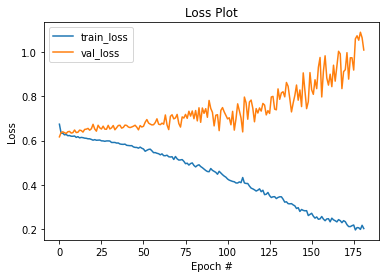

In [128]:
h = pd.DataFrame(h.history)
epochs = np.arange(0, len(h["loss"]))
plt.plot(epochs, h["loss"], label="train_loss")
plt.plot(epochs, h["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("Loss.png")
plt.show()

In [114]:
mm.evalution(x_test,y_test,model)

混同行列[[107  59]
 [ 46  25]]
正解率は0.5569620253164557 適合率は0.6993464052287581 再現率は0.6445783132530121 F値は0.670846394984326


In [116]:
x_test_close=data_close[(len(data_close)-len(x_test))-1:-1]
value = mm.baibai(x_test,model,x_test_close)
print(value)

30.0


In [49]:
model.save("my_model2")
#reconstructed_model = tf.keras.models.load_model("my_model")
#mm.draw_tran_result(reconstructed_model, x_test, y_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model2\assets


In [60]:
x_train_sfs=data.iloc[:,:-1]
y_train_sfs=data.iloc[:,-1]

sfs1 = SFS(RandomForestClassifier(), # 使う学習器
           k_features=10, #特徴をいくつまで選択するか
           forward=True, #Trueでforward selectionになる。Falseでback
           floating=False, #後に説明するが、forward selectionの亜種を行うためのもの。
           verbose=2, #実行時のlogをどれだけ詳しく表示するか
           scoring='accuracy', # 評価指標
           cv=5) #クロスバリデーション
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

sfs1 = sfs1.fit(x_train_sfs,y_train_sfs)

selected_feat = x_train_sfs.columns[list(sfs1.k_feature_idx_)]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   19.5s finished

[2022-06-17 13:56:05] Features: 1/10 -- score: 0.6666666666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   17.7s finished

[2022-06-17 13:56:23] Features: 2/10 -- score: 0.6666666666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   17.1s finished

[2022-06-17 13:56:40] Features: 3/10 -- score: 0.6602150537634408[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [61]:
sfs1.subsets_

{1: {'feature_idx': (24,),
  'cv_scores': array([0.67741935, 0.6344086 , 0.67741935, 0.67741935, 0.66666667]),
  'avg_score': 0.6666666666666666,
  'feature_names': ('MACDクロス',)},
 2: {'feature_idx': (20, 24),
  'cv_scores': array([0.67741935, 0.6344086 , 0.67741935, 0.67741935, 0.66666667]),
  'avg_score': 0.6666666666666666,
  'feature_names': ('25-75クロス', 'MACDクロス')},
 3: {'feature_idx': (20, 21, 24),
  'cv_scores': array([0.67741935, 0.60215054, 0.67741935, 0.67741935, 0.66666667]),
  'avg_score': 0.6602150537634408,
  'feature_names': ('25-75クロス', 'ボリンジャーバンドボーダー', 'MACDクロス')},
 4: {'feature_idx': (19, 20, 21, 24),
  'cv_scores': array([0.67741935, 0.60215054, 0.66666667, 0.67741935, 0.66666667]),
  'avg_score': 0.6580645161290322,
  'feature_names': ('5-25クロス', '25-75クロス', 'ボリンジャーバンドボーダー', 'MACDクロス')},
 5: {'feature_idx': (17, 19, 20, 21, 24),
  'cv_scores': array([0.66666667, 0.60215054, 0.64516129, 0.6344086 , 0.6344086 ]),
  'avg_score': 0.6365591397849462,
  'feature_names': (